In [13]:
import os
from utils.auxiliary_func import *
from utils.plots_func import *
from flim_analysis.spatial_analysis.spatial_func import *
import config.const as const

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from PIL import Image
import tifffile
from tqdm import tqdm

### Note on Data Preparation

The data used in this notebook was generated in the following notebook:

**`TNBC_FLIM/flim_analysis/spatial_analysis/spatial_information.ipynb`**

Please make sure to run that notebook first to prepare the necessary data files before executing this one.

## Define Parameters

In [14]:
patch_size = 1500
overlap = 0.75
fold_method='stratified_kfold'

In [15]:
figure_2_dir = os.path.join(const.base_dir, 'figure_results', 'Figure 2')
os.makedirs(figure_2_dir, exist_ok=True)

data_preparation_dir = os.path.join(const.base_dir, 'figure_results', 'data_preparation')

figure_supplementary_dir = os.path.join(const.base_dir, 'figure_results', 'Supplementary')
os.makedirs(figure_supplementary_dir, exist_ok=True)

## Probability maps

In [16]:
file_path = os.path.join(data_preparation_dir, f'mean_prob_patch_size_{patch_size}_for_each_nucleus.csv')
flim_classification_probabilities = pd.read_csv(file_path, dtype={'leap_ID': str})

In [17]:
flim_classification_probabilities.head()

,nucleus_label,leap_ID,lifetime_mean,X coordinate,Y coordinate,category,prob_results
0,1,015,4.114694,3662.775510,1900.285714,non responder,0.510318
1,1,017,4.067597,2863.145161,3150.403226,non responder,0.636030
2,1,019,4.099839,3291.403226,1459.112903,non responder,0.775295
3,1,021,4.631462,2815.384615,2049.615385,responder,0.242873
4,1,023,4.368353,2224.588235,1628.117647,responder,0.489741


### Plot the probability maps

Responders: 100%|██████████| 30/30 [02:02<00:00,  4.08s/it]
/tmp/ipykernel_3977858/3891051888.py:50: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


Responders


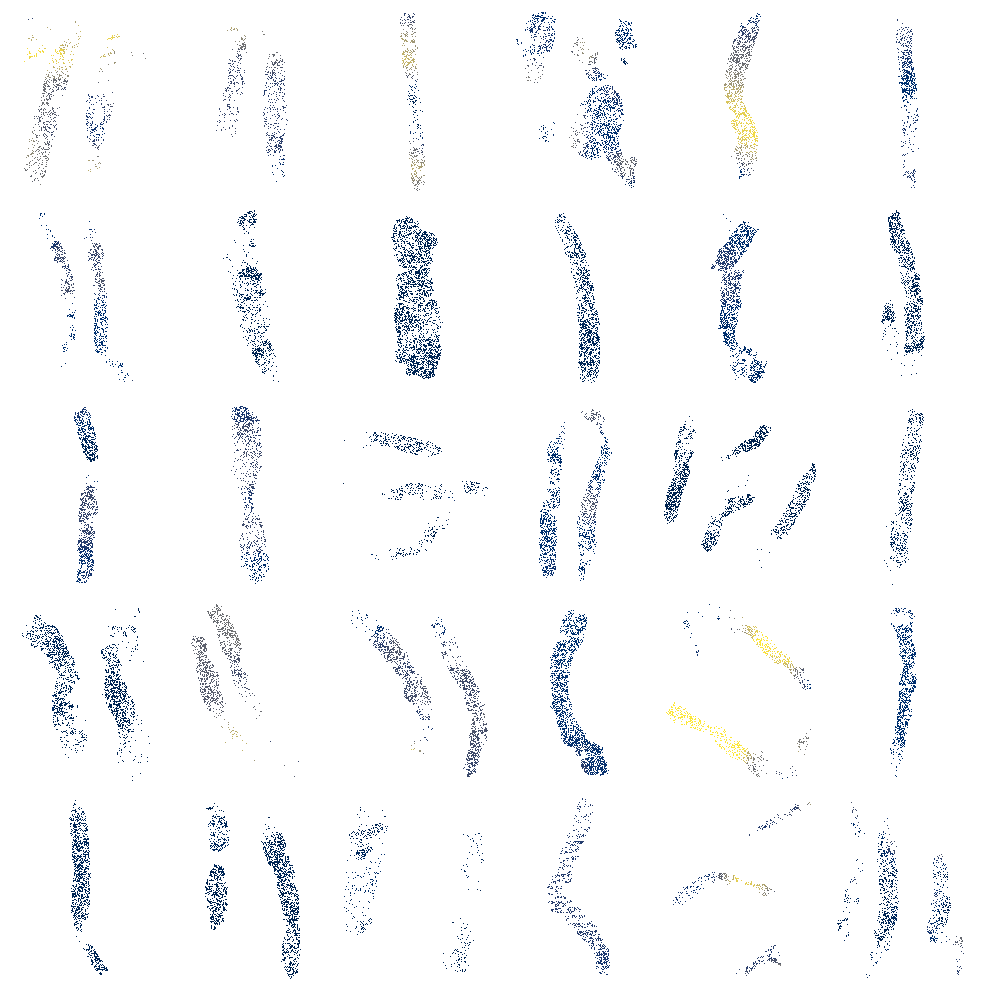

Non-Responders: 100%|██████████| 23/23 [01:01<00:00,  2.68s/it]
/tmp/ipykernel_3977858/3891051888.py:50: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


Non-Responders


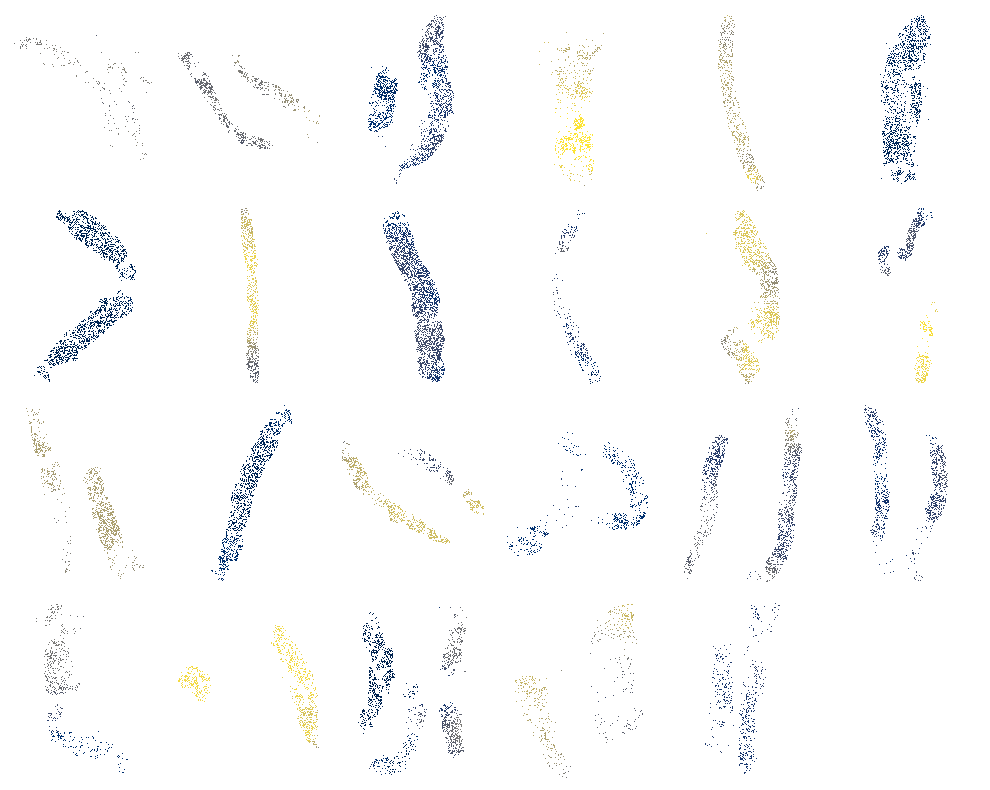

In [19]:
# Split into two groups
responders = flim_classification_probabilities[
    flim_classification_probabilities["category"] == "responder"
]["leap_ID"].unique()

non_responders = flim_classification_probabilities[
    flim_classification_probabilities["category"] == "non responder"
]["leap_ID"].unique()

groups = {
    "Responders": responders,
    "Non-Responders": non_responders,
}

for group_name, leap_ids in groups.items():
    total_panels = len(leap_ids)
    ncols = 6
    nrows = int(np.ceil(total_panels / ncols))

    fig, axes = plt.subplots(
        nrows=nrows, ncols=ncols, figsize=(10, 2 * nrows), constrained_layout=True
    )

    if total_panels == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for leap_num, ax in tqdm(zip(leap_ids, axes), total=total_panels, desc=group_name):
        leap_id = f"{str(leap_num).zfill(3)}"

        flim_prob_path = os.path.join(const.flim_model_probability_dir, f'Leap{leap_id}_flim_probability.tif')

        flim_single_nuclear_probabilities = io.imread(flim_prob_path)

        ax.imshow(
            flim_single_nuclear_probabilities,
            cmap="cividis_r",
            vmax=1.0,
            vmin=0.0,
            interpolation="nearest",
        )
        
        ax.axis("off")

    # Turn off unused axes
    for ax in axes[total_panels:]:
        ax.axis("off")

    print(f"{group_name}")
    plt.tight_layout()

    save_file_name = f"probability_maps_{group_name}"
    # save_fig(figure_supplementary_dir, save_file_name, 'png', plt, transparent=False)
    
    plt.show()


## Probability vs lifetime value analysis

In [20]:
radii = [40, 80, 120]
radius_colors = {40: 'orange', 80: 'blue', 120: 'gray'}

In [21]:
file_path = os.path.join(data_preparation_dir, f'mean_prob_patch_size_{patch_size}_for_each_nucleus.csv')

best_hist_aggregated_df_1500 = pd.read_csv(file_path, dtype={'leap_ID': str})
best_hist_aggregated_df_1500.head(2)

,nucleus_label,leap_ID,lifetime_mean,X coordinate,Y coordinate,category,prob_results
0,1,015,4.114694,3662.775510,1900.285714,non responder,0.510318
1,1,017,4.067597,2863.145161,3150.403226,non responder,0.636030


In [22]:
file_name = 'all_probability_coords.csv'
prob_coords_leap_file_path = os.path.join(data_preparation_dir, file_name)
prob_coords_df = pd.read_csv(prob_coords_leap_file_path, dtype={'leap_ID':str})
prob_coords_df.head(2)

,transition_type,leap_ID,index,shape-type,vertex-index,axis-0,axis-1
0,homogeneous_heterogeneous,073,0,path,1,5889.238610,5510.651995
1,homogeneous_heterogeneous,073,0,path,2,5499.545451,4943.825583


### Transition from Responder to Non responder region

In [23]:
transition_type = 'heterogeneous'
responder_leaps = ['066', '038']
non_responder_leaps = ['073', '048']
leaps_list = responder_leaps + non_responder_leaps

leap - 066


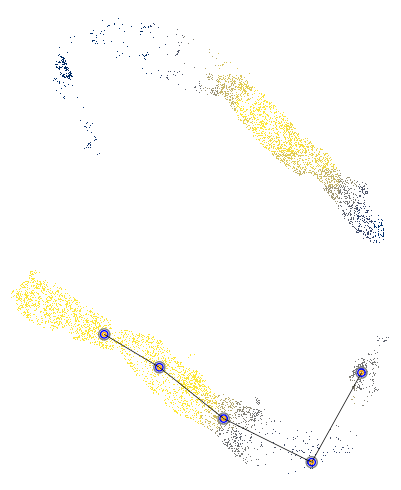

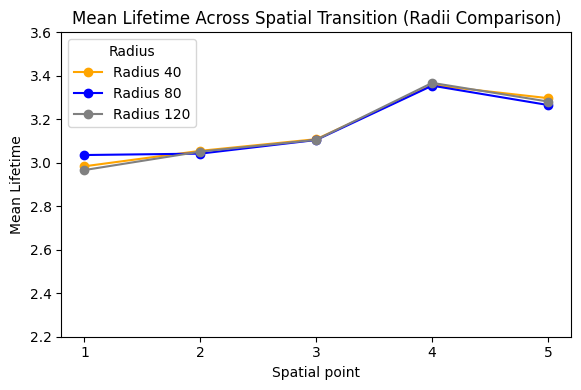

leap - 038


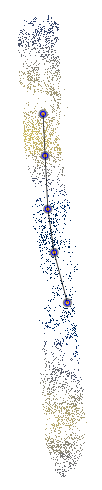

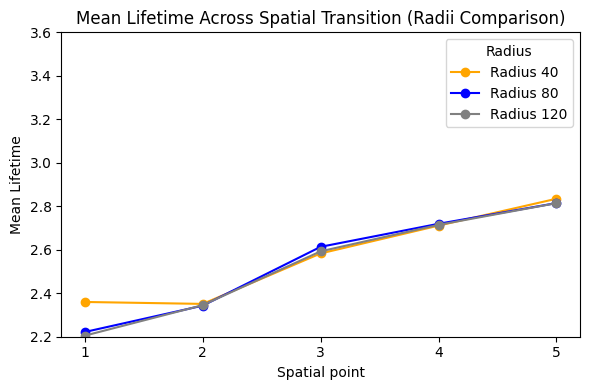

leap - 073


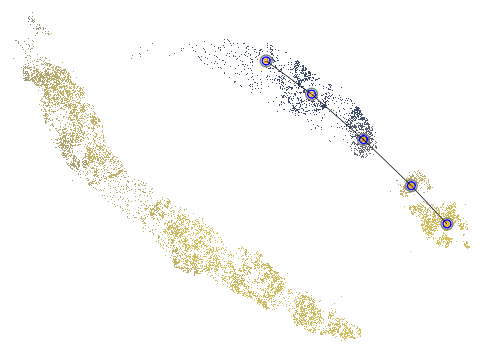

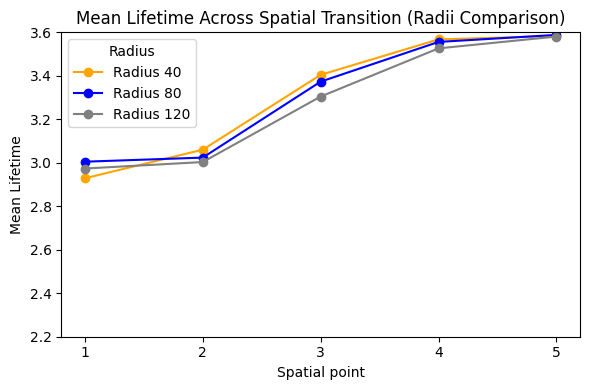

leap - 048


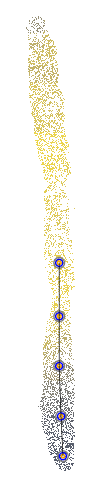

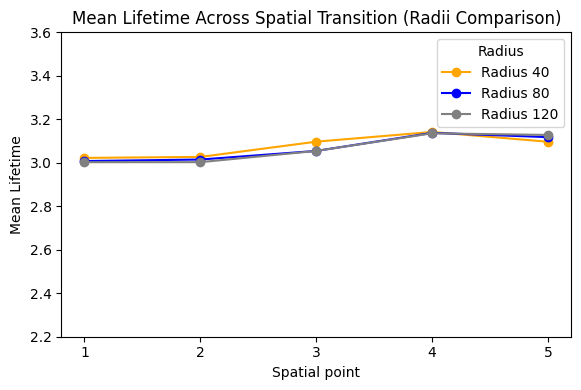

In [17]:
for leap_id in leaps_list: 
    print(f"leap - {leap_id}")
    prob_coords_df_leap = prob_coords_df[(prob_coords_df['leap_ID'] == leap_id) & (prob_coords_df['transition_type'] == transition_type)]
    plot_one_transition(leap_id=leap_id, prob_coords=prob_coords_df_leap, lifetime_and_prob_df=best_hist_aggregated_df_1500, radius_list=radii, radius_colors_dict=radius_colors, figure_save_dir=figure_supplementary_dir ,save_plot=False)

### Transition in homogeneous region - Responder or Non responder

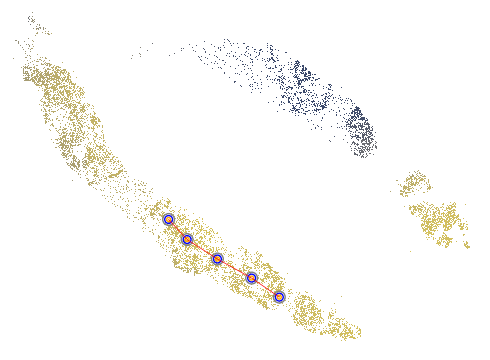

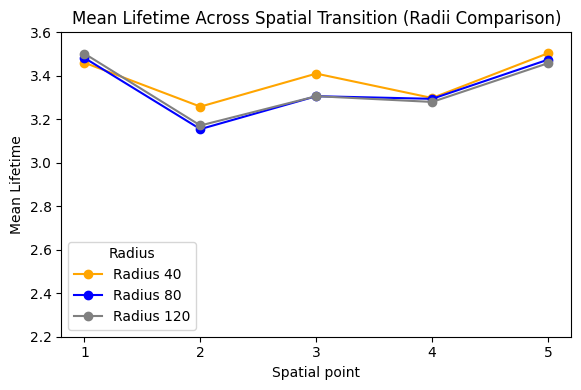

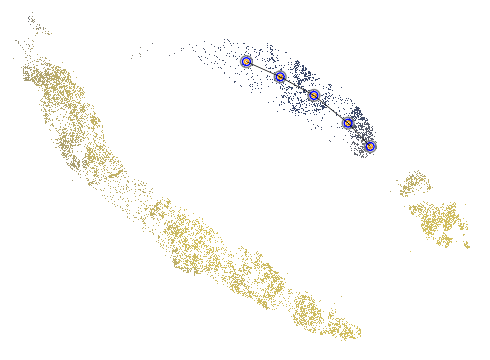

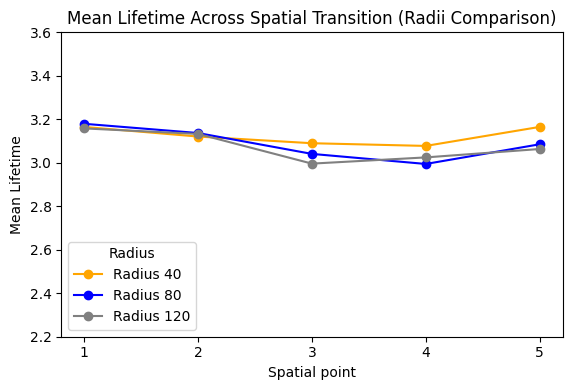

In [18]:
leap_id = '073'
transition_type = 'homogeneous'
prob_coords_df_leap = prob_coords_df[(prob_coords_df['leap_ID'] == leap_id) & (prob_coords_df['transition_type'] == transition_type)]
plot_one_transition(leap_id=leap_id, prob_coords=prob_coords_df_leap, lifetime_and_prob_df=best_hist_aggregated_df_1500, radius_list=radii, radius_colors_dict=radius_colors, path_colors = ['red', 'black'], figure_save_dir=figure_supplementary_dir ,save_plot=False)


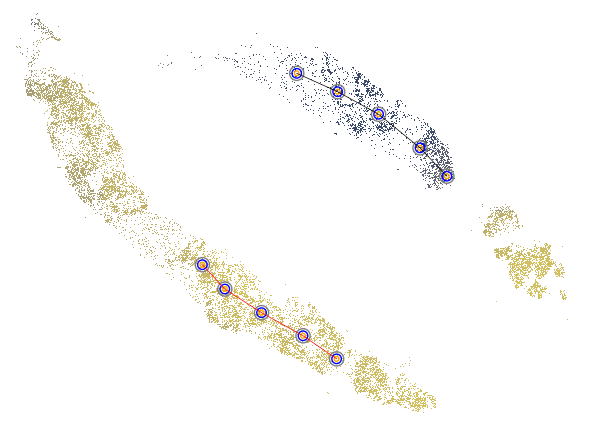

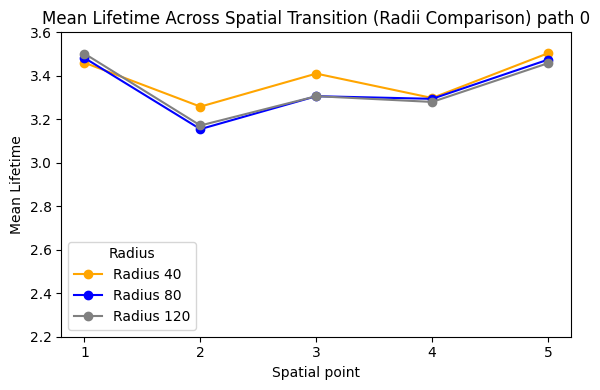

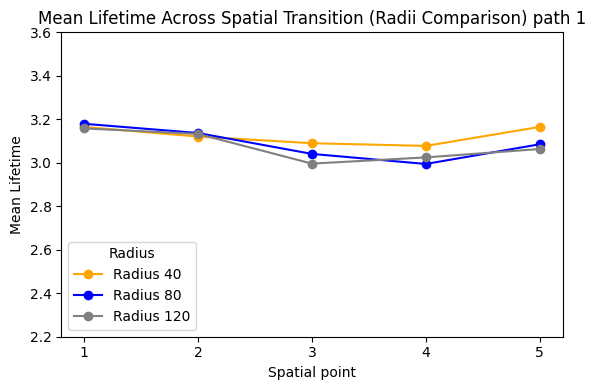

In [12]:
leap_id = '073'
transition_type = 'homogeneous'
prob_coords_df_leap = prob_coords_df[(prob_coords_df['leap_ID'] == leap_id) & (prob_coords_df['transition_type'] == transition_type)]
plot_transition_2_path_homo_region(val_min=0.1, leap_id=leap_id, prob_coords=prob_coords_df_leap, lifetime_and_prob_df=best_hist_aggregated_df_1500, radius_list=radii, radius_colors_dict=radius_colors, path_colors = ['red', 'black'], figure_save_dir=figure_supplementary_dir ,save_plot=False)
